In [1]:
import pandas as pd
import regex as re
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

In [41]:
# there are some unique encodings in the data set so we must use a more flexible encoding than utf-8
crowd_data = pd.read_csv("dataverse_files/ccc_compiled_20212024.csv", encoding='latin-1')
crowd_data.drop(columns=['source_1', 'source_2',
       'source_3', 'source_4', 'source_5', 'source_6', 'source_7', 'source_8',
       'source_9', 'source_10', 'source_11', 'source_12', 'source_13',
       'source_14', 'source_15', 'source_16', 'source_17', 'source_18',
       'source_19', 'source_20', 'source_21', 'source_22', 'source_23',
       'source_24', 'source_25', 'source_26', 'source_27', 'source_28',
       'source_29', 'source_30', 'notes', 'lat', 'lon', 'resolved_locality',
       'resolved_county', 'resolved_state', 'fips_code'], inplace=True)

/var/folders/dd/mm7wxnvj0fn_gq9q2bd034sm0000gn/T/ipykernel_19855/1955454331.py:2: DtypeWarning: Columns (22,24,26,33,34,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  crowd_data = pd.read_csv("dataverse_files/ccc_compiled_20212024.csv", encoding='latin-1')


In [42]:
crowd_data['date'] = pd.to_datetime(crowd_data['date'])
start_date = pd.to_datetime("2024-04-1")
end_date = pd.to_datetime("2024-07-31")
mask = (crowd_data['date'] >= start_date) & (crowd_data['date'] <= end_date)
crowd_data = crowd_data[mask]

In [43]:
key_phrases = ['divest', 'israel', 'palestine', 'divestment', 'liberation', 'palestinian', 'gaza', 'genocide']
regex = '|'.join(key_phrases)
crowd_data['claims'] = crowd_data['claims'].str.lower()
mask = crowd_data['claims'].str.contains(regex)
crowd_data = crowd_data[mask]

In [44]:
crowd_data.drop(columns = ['location_detail', 'online', 'type',
       'title', 'macroevent', 'organizations', 'participants', 'claims',
       'claims_summary', 'claims_verbatim', 'issue_tags_summary',
       'issue_tags_verbatim', 'issue_tags', 'valence',
       'size_cat', 'property_damage', 'property_damage_any',
       'chemical_agents', 'arrests_any', 'injuries_crowd_any', 'injuries_police_any', 'participant_deaths',
       'police_deaths', 'size_text'], inplace=True)

In [45]:
def parse_mixed(value):
    #NA case
    if pd.isna(value):
        return 0
    
    #value is already a number
    if isinstance(value, int) or isinstance(value, float):
        return float(value)
    
    #unclear/unspecified
    pattern = r'unspecified|unclear'
    if re.search(pattern, value):
        return pd.NA  # you can later impute with mean/median nonzero
    
    #"above value" case (in this just do 1 more than the value for a lower bound)
    pattern = r'(?:more than|over)\s+(\d+)'
    match = re.findall(pattern, value)
    if len(match) > 0:
        return float(match[0]) + 1
    
    #single number case
    pattern = r'(\d+)'
    match = re.findall(pattern, value)
    if len(match) > 0:
        return float(match[0])
    
    #catch all case
    return pd.NA

In [46]:
crowd_data['injuries_crowd'] = crowd_data['injuries_crowd'].apply(parse_mixed)
crowd_data['arrests'] = crowd_data['arrests'].apply(parse_mixed)
crowd_data['injuries_police'] = crowd_data['injuries_police'].apply(parse_mixed)
crowd_data['participant_measures'] = crowd_data['participant_measures'].astype(str)
crowd_data['police_measures'] = crowd_data['participant_measures'].astype(str)
print(crowd_data.columns)

Index(['date', 'locality', 'state', 'size_low', 'size_high', 'size_mean',
       'arrests', 'injuries_crowd', 'injuries_police', 'participant_measures',
       'police_measures'],
      dtype='object')


In [47]:
crowd_data['removed'] = 0

In [32]:
mask = (crowd_data['locality'] == 'Chandler') & (crowd_data['size_mean'].isna())
first_index = crowd_data.loc[mask].index[0]
crowd_data['removed'][first_index] = 5
print(first_index)

print(crowd_data['removed'][crowd_data['locality'] == 'Chandler']) #crowd_data['locality'] == city & crowd_data['size_mean'] == np.nan

110924
109351    0
109420    0
109496    0
109588    0
109676    0
110217    0
110377    0
110486    0
110924    5
115506    0
116780    0
Name: removed, dtype: int64


/var/folders/dd/mm7wxnvj0fn_gq9q2bd034sm0000gn/T/ipykernel_19855/2434640759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crowd_data['removed'][first_index] = 5


In [56]:
print(crowd_data[crowd_data['locality'] == 'North Newton'])

             date      locality state  size_low  size_high  size_mean arrests  \
109536 2024-04-03  North Newton    KS      20.0       30.0       25.0       0   

       injuries_crowd injuries_police  \
109536              0               0   

                                     participant_measures  \
109536  took turns ringing the college's historic bell...   

                                          police_measures  removed  
109536  took turns ringing the college's historic bell...      0.0  


In [63]:
cities = crowd_data["locality"].unique()
dates = pd.date_range(crowd_data["date"].min(), crowd_data["date"].max())

full_index = pd.MultiIndex.from_product([cities, dates], names=["locality", "date"])

crowd_data_unique = (
    crowd_data
    .groupby(["locality", "date"], as_index=False)
    .sum(numeric_only=True)
)

crowd_data = crowd_data_unique.set_index(["locality", "date"]).reindex(full_index).reset_index()

In [67]:
print(crowd_data[crowd_data['locality'] == 'Chandler'])

     locality       date  size_low  size_high  size_mean  removed
0    Chandler 2024-04-01       2.0        2.0        2.0      0.0
1    Chandler 2024-04-02       1.0        1.0        1.0      0.0
2    Chandler 2024-04-03       2.0        3.0        2.0      0.0
3    Chandler 2024-04-04       6.0        8.0        7.0      0.0
4    Chandler 2024-04-05      10.0       15.0       12.0      0.0
..        ...        ...       ...        ...        ...      ...
117  Chandler 2024-07-27       0.0        0.0        0.0      0.0
118  Chandler 2024-07-28       0.0        0.0        0.0      0.0
119  Chandler 2024-07-29       0.0        0.0        0.0      0.0
120  Chandler 2024-07-30       0.0        0.0        0.0      0.0
121  Chandler 2024-07-31       0.0        0.0        0.0      0.0

[122 rows x 6 columns]


In [65]:
for city in crowd_data['locality'].unique():

    total_protestors = np.max(crowd_data['size_mean'][crowd_data['locality'] == city].cumsum())

    mask = (crowd_data['locality'] == city) & (crowd_data['size_mean'].isna())
    if crowd_data['size_mean'][crowd_data['locality'] == city].isna().all():
        continue
    else:
        first_index = crowd_data.loc[mask].index[0]
        crowd_data['removed'][first_index:] = total_protestors

IndexError: index 0 is out of bounds for axis 0 with size 0

In [51]:
print(crowd_data[['size_mean', 'arrests', 'injuries_crowd', 'removed']][crowd_data['locality'] == 'Chandler'])

        size_mean arrests injuries_crowd  removed
109351        2.0       0              0      0.0
109420        1.0       0              0      0.0
109496        2.0       0              0      0.0
109588        7.0       0              0      0.0
109676       12.0       0              0      0.0
110217        1.0       0              0      0.0
110377        4.0       0              0      0.0
110486        4.0       0              0      0.0
110924        NaN       0              0      0.0
115506        NaN       0              0      0.0
116780        NaN       0              0      0.0


In [36]:
agg_dict = {
    'size_low': 'sum',
    'size_high': 'sum',
    'size_mean': 'sum',
    'removed': 'sum',
    'arrests': 'sum',
    'injuries_crowd': 'sum',
    'injuries_police': 'sum',
    'participant_measures': lambda x: ' ; '.join(x),
    'police_measures': lambda x: ' ; '.join(x)
}

crowd_data_new = crowd_data.groupby('date').agg(agg_dict)

<AxesSubplot: xlabel='date'>

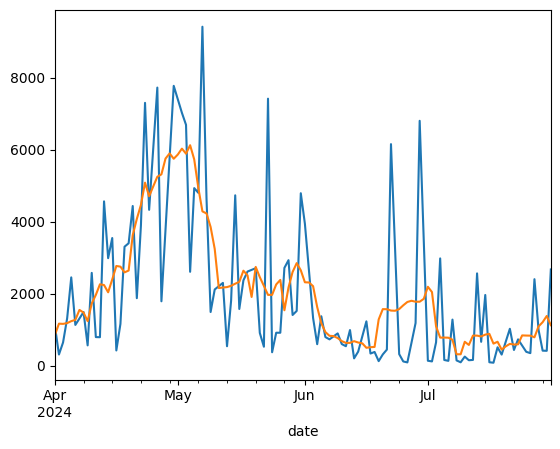

In [37]:
numeric_columns = ['size_low', 'size_high', 'size_mean', 'arrests', 'injuries_crowd',
       'injuries_police']
mean_sizes = crowd_data_new['size_mean'].copy()
q1 = mean_sizes.quantile(0.25)
q3 = mean_sizes.quantile(0.75)
IQR = q3 - q1
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

# Mask for outliers
outlier_mask = (mean_sizes < lower_bound) | (mean_sizes > upper_bound)

# Replace outliers with NaN for smoothing
crowd_data_new.loc[outlier_mask, numeric_columns] = np.nan
crowd_data_new[numeric_columns] = crowd_data_new[numeric_columns].interpolate(method='linear')

crowd_data_new['size_mean'].plot()

smoothed_data = crowd_data_new.copy()
smoothed_data[numeric_columns] = smoothed_data[numeric_columns].rolling(window=7, center=True, min_periods=1).mean()  # rolling smoothing
smoothed_data['size_mean'].plot()

In [38]:
crowd_data_new['removed'] = crowd_data_new['removed'].cumsum()

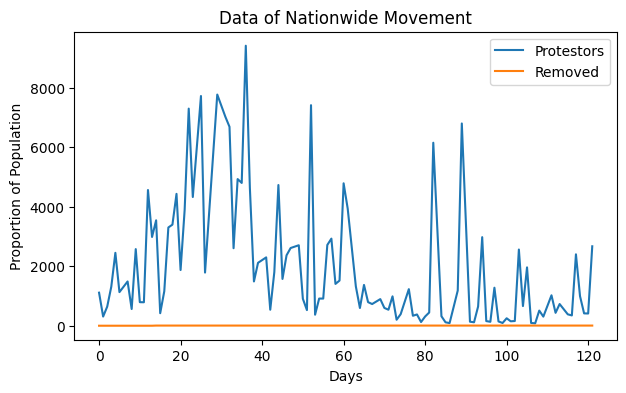

In [39]:
t = np.arange(0, 122)


# plot data
plt.figure(figsize=(7, 4))
plt.plot(t, crowd_data_new['size_mean'], label='Protestors')
plt.plot(t, crowd_data_new['removed'], label='Removed')
plt.xlabel("Days")
plt.ylabel("Proportion of Population")
plt.title(f"Data of Nationwide Movement")
plt.legend()
plt.show()